In [133]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data
import torchvision
from torchvision import transforms

import numpy as np
import matplotlib.pyplot as plt
import os
import glob
from PIL import Image

In [134]:
torch.cuda.is_available()

True

In [135]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=0.5, std=0.5)
])

In [136]:
dataset = torchvision.datasets.MNIST('data',
                                    train=True,
                                    transform=transform,
                                    download=True)

In [137]:
len(dataset)

60000

In [138]:
train_label_size = 1000
train_unlabel_size = len(dataset)-train_label_size

In [139]:
label_ds, unlabel_ds = torch.utils.data.random_split(dataset,
                                                    [train_label_size, 
                                                    train_unlabel_size])

In [140]:
len(label_ds), len(unlabel_ds)

(1000, 59000)

In [141]:
test_ds = torchvision.datasets.MNIST('data',
                                    train=False,
                                    transform=transform,
                                    download=True)

In [142]:
len(test_ds)

10000

In [143]:
label_dl = data.DataLoader(label_ds,
                          batch_size = 256,
                          shuffle=True)

In [144]:
unlabel_dl = data.DataLoader(unlabel_ds,
                          batch_size = 256,
                          shuffle=True)

In [145]:
test_dl = data.DataLoader(test_ds,
                          batch_size = 256)

In [146]:
len(test_dl) ,len(test_dl.dataset)

(40, 10000)

In [147]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [148]:
def test(dataloader, model, loss_fn):
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)   #一共有多少个batch
    test_loss, correct = 0, 0
    for x, y in dataloader:
        x, y =x.to(device), y.to(device)
        pred , _= model(x)
        test_loss += loss_fn(pred, y)
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches  #损失是单个批次内所有样本的总损失
    correct /= size            #准确率所有样本的准确率
    return test_loss, correct

In [149]:
#定义生成器
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.linear1 = nn.Linear(100, 256*7*7)
        self.bn1 = nn.BatchNorm1d(256*7*7)
        self.deconv1 = nn.ConvTranspose2d(256, 128, 
                                          kernel_size=(3, 3), 
                                          padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.deconv2 = nn.ConvTranspose2d(128, 64, 
                                          kernel_size=(4, 4),
                                          stride=2, 
                                          padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.deconv3 = nn.ConvTranspose2d(64, 1, 
                                          kernel_size=(4, 4), 
                                          stride=2, 
                                          padding=1)
            
    def forward(self, x):
        x = F.relu(self.linear1(x))
        x = self.bn1(x)
        x = x.view(-1, 256, 7, 7)
        x = F.relu(self.deconv1(x))
        x = self.bn2(x)
        x = F.relu(self.deconv2(x))
        x = self.bn3(x)
        x = torch.tanh(self.deconv3(x))
        return x

In [150]:
# 定义判别器
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, 3, 2)
        self.conv2 = nn.Conv2d(64, 128, 3, 2)
        self.bn = nn.BatchNorm2d(128)
        self.fc1 = nn.Linear(128*6*6, 10)
        self.fc2 = nn.Linear(128*6*6, 1)

    def forward(self, x):
        x = F.dropout2d(F.leaky_relu(self.conv1(x)))
        x = F.dropout2d(F.leaky_relu(self.conv2(x)))
        x = self.bn(x)
        x = x.view(-1, 128*6*6)   # (batch, 128, 6, 6)  -> (batch, 128*6*6)
        class_out = self.fc1(x)
        real_fake_out = self.fc2(x)
        return class_out, real_fake_out

In [151]:
gen = Generator().to(device)
dis = Discriminator().to(device)

In [152]:
#定义损失计算函数
loss_classes_fn = nn.CrossEntropyLoss()
loss_sigmoid_fn = nn.BCEWithLogitsLoss()  #对应二分类的未激活输出

In [153]:
d_optimizer = torch.optim.Adam(dis.parameters(), lr=0.00002)
g_optimizer = torch.optim.Adam(gen.parameters(), lr=0.0001)

In [154]:
# 定义可视化函数
def generate_and_save_images(model, epoch, test_input):
    # np.squeeze去掉长度为1的维度
    predictions = np.squeeze(model(test_input)).detach().cpu().numpy()
    fig = plt.figure(figsize=(20, 160))                             # 可视化16张图片
    for i in range(predictions.shape[0]):
        plt.subplot(1, 8, i+1)
        plt.imshow((predictions[i] + 1)/2)          # 注意取值范围的转换
        plt.axis('off')
    # plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()
# 设置生成绘图图片的随机张量，这里可视化16张图片
# 生成16个长度为100的随机正态分布张量
test_seed = torch.randn(8, 100, device=device)

In [155]:
D_LOSS = []
G_LOSS = []

Epoch: 0 Test_loss:1.60 Test_acc:0.54


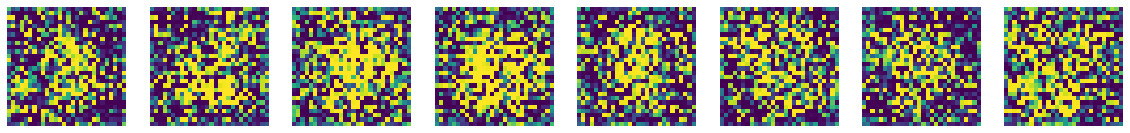

Epoch: 10 Test_loss:0.36 Test_acc:0.89


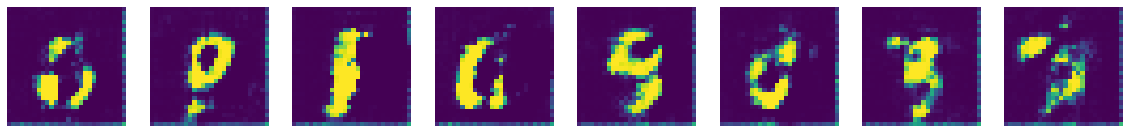

Epoch: 20 Test_loss:0.32 Test_acc:0.91


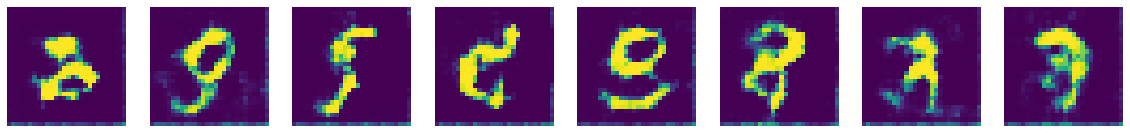

Epoch: 30 Test_loss:0.31 Test_acc:0.92


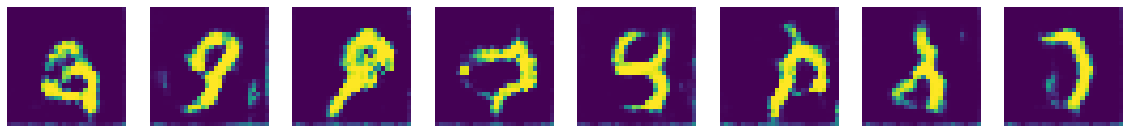

Epoch: 40 Test_loss:0.29 Test_acc:0.92


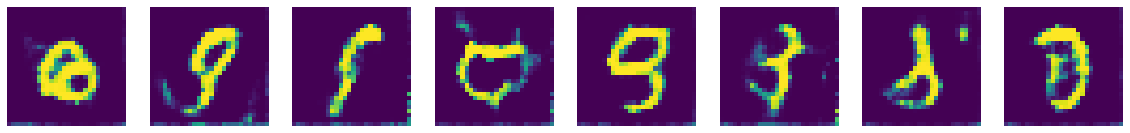

Epoch: 50 Test_loss:0.28 Test_acc:0.92


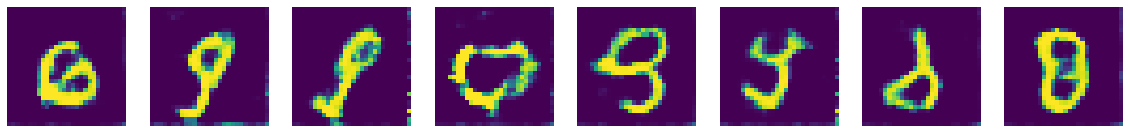

Epoch: 60 Test_loss:0.28 Test_acc:0.92


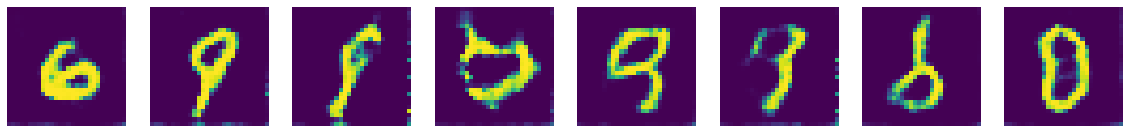

Epoch: 70 Test_loss:0.27 Test_acc:0.93


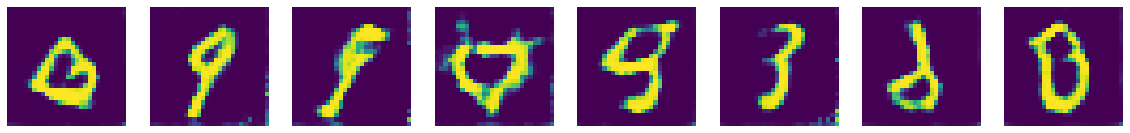

Epoch: 80 Test_loss:0.28 Test_acc:0.93


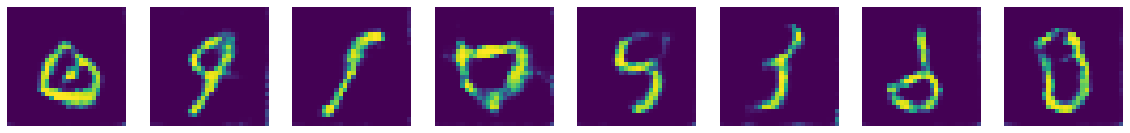

Epoch: 90 Test_loss:0.28 Test_acc:0.93


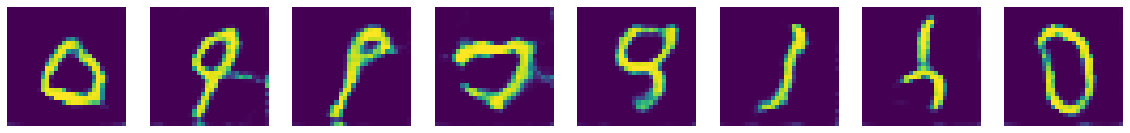

Epoch: 100 Test_loss:0.27 Test_acc:0.93


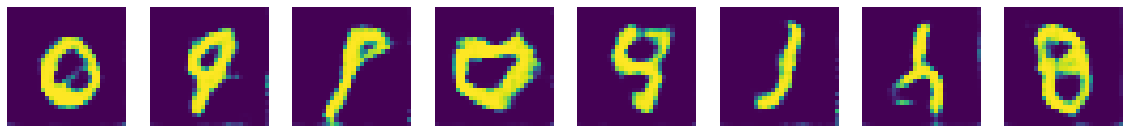

Epoch: 110 Test_loss:0.27 Test_acc:0.93


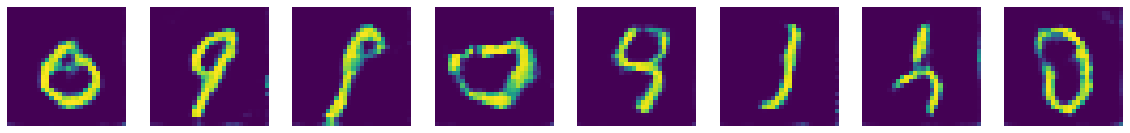

Epoch: 120 Test_loss:0.28 Test_acc:0.93


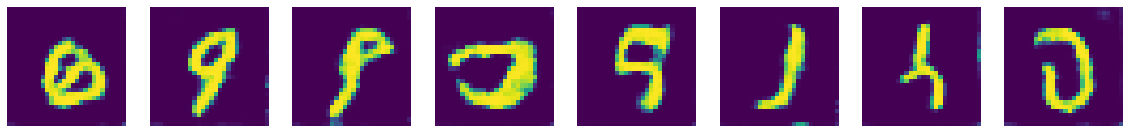

Epoch: 130 Test_loss:0.27 Test_acc:0.94


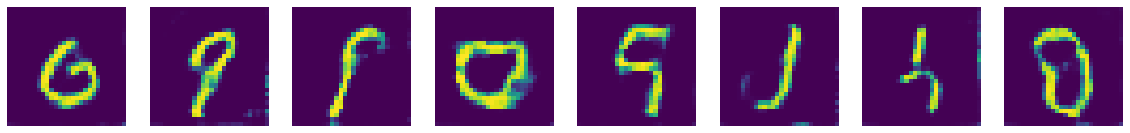

Epoch: 140 Test_loss:0.28 Test_acc:0.94


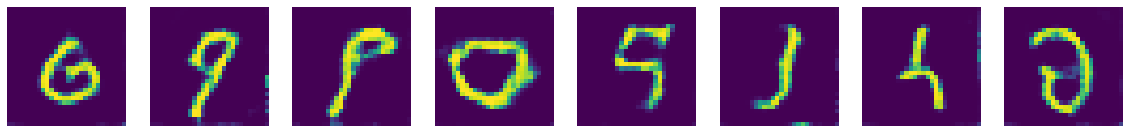

Epoch: 150 Test_loss:0.26 Test_acc:0.94


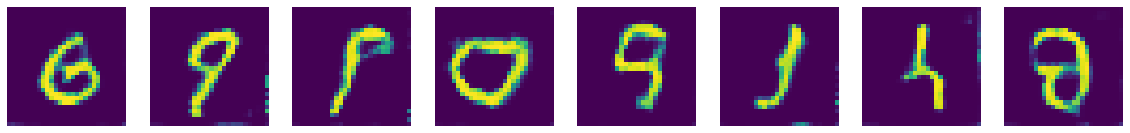

Epoch: 160 Test_loss:0.27 Test_acc:0.93


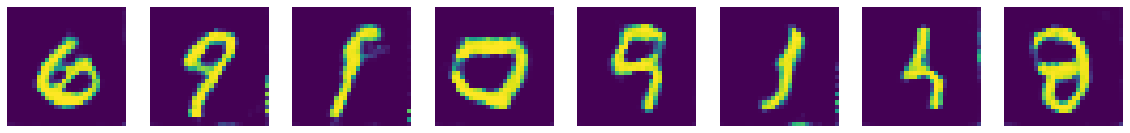

Epoch: 170 Test_loss:0.26 Test_acc:0.94


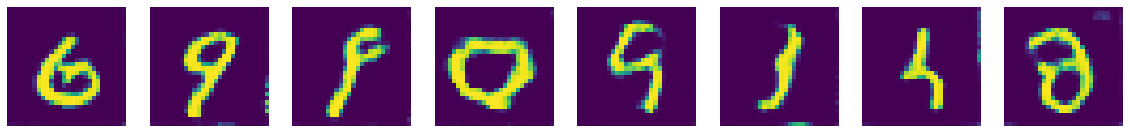

Epoch: 180 Test_loss:0.27 Test_acc:0.94


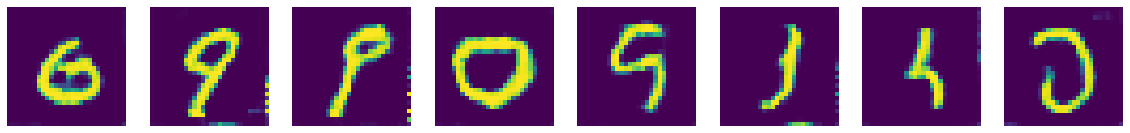

Epoch: 190 Test_loss:0.26 Test_acc:0.94


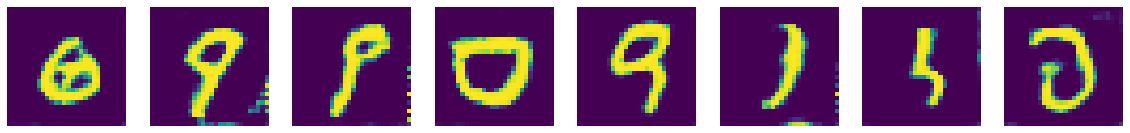

KeyboardInterrupt: 

In [156]:
for epoch in range(300):
    D_epoch_loss = 0
    G_epoch_loss = 0
    count = len(unlabel_dl)  #共有几个批次
    for unlb_img, _ in unlabel_dl:
        unlb_img = unlb_img.to(device)
        size = unlb_img.shape[0]
        random_noise = torch.randn(size, 100, device=device)
        
        lb_img, label = next(iter(label_dl))
        lb_img, label = lb_img.to(device), label.to(device)
        
        d_optimizer.zero_grad()
        
        #计算未标注数据的损失
        _, real_sg_out = dis(unlb_img)
        d_real_sg_loss = loss_sigmoid_fn(real_sg_out, torch.ones_like(real_sg_out, device = device))
        d_real_sg_loss.backward()
        
        #计算生成数据损失
        generated_img = gen(random_noise)
        _, fake_sg_out = dis(generated_img.detach())
        d_fake_sg_loss = loss_sigmoid_fn(fake_sg_out, torch.zeros_like(fake_sg_out, device=device))
        d_fake_sg_loss.backward()
        
        #计算标注数据的损失
        d_real_sfm_out, _ = dis(lb_img)
        d_real_sfm_loss = loss_classes_fn(d_real_sfm_out, label)
        d_real_sfm_loss.backward()
        
        
        d_loss = d_real_sg_loss + d_fake_sg_loss + d_real_sfm_loss
        d_optimizer.step()
        
        #生成器损失
        g_optimizer.zero_grad()
        _, fake_out = dis(generated_img)
        g_loss  = loss_sigmoid_fn(fake_out, torch.ones_like(fake_out, device=device))
        g_loss.backward()
        g_optimizer.step()
        
        
        with torch.no_grad():
            D_epoch_loss += d_loss.item()
            G_epoch_loss += g_loss.item()
    with torch.no_grad():
        D_epoch_loss /= count
        G_epoch_loss /= count
        D_LOSS.append(D_epoch_loss)
        G_LOSS.append(G_epoch_loss)
        if epoch%10 == 0:
            test_loss, test_acc = test(test_dl, dis, loss_classes_fn)
            print('Epoch:',epoch,
                 'Test_loss:{:.2f}'.format(test_loss),
                 'Test_acc:{:.2f}'.format(test_acc))
            generate_and_save_images(gen, epoch, test_seed)